# Fake news classifier

## 1. imports

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
# Bag-of-Words transformers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # Support Vector Classification
# Model evaluation
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import precision_score, recall_score
# Model export
import pickle

## 2. check the dataset

In [2]:
df = pd.read_csv('data/fake-news/fake_or_real_news.csv')

In [3]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
df.shape

(6335, 4)

In [5]:
df['label'].value_counts() # normalize=True

REAL    3171
FAKE    3164
Name: label, dtype: int64

**There are no missing values in the dataset.**

In [6]:
df.isnull().values.any()

False

## 3. split the dataset into training set and test set

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.33, random_state=42)

In [8]:
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')

X_train shape: (4244,)
X_test shape: (2091,)


In [9]:
type(X_train)

pandas.core.series.Series

In [10]:
X_train.head()

5593    The next president is most likely to face an i...
6067    Following news of FBI Director James Comey’s d...
3026    Interviews A protester throws a glass bottle c...
4385    Will it be representative government or thugoc...
120     It is increasingly apparent that the U.S. war ...
Name: text, dtype: object

In [11]:
X_train.index[:10]

Int64Index([5593, 6067, 3026, 4385, 120, 1777, 6129, 5085, 3123, 3639], dtype='int64')

In [12]:
X_train.values[0][:100]

'The next president is most likely to face an international crisis shortly after taking office — and '

In [13]:
y_train.head()

5593    REAL
6067    FAKE
3026    FAKE
4385    FAKE
120     REAL
Name: label, dtype: object

## 4. bag-of-words with CountVectorizer

In [14]:
count_vectorizer = CountVectorizer(stop_words='english') # delete english stop words like I, me, my...

In [15]:
X_countvec_train = count_vectorizer.fit_transform(X_train.values) 
# .fit() creates the bag-of-words
# .transform() transforms the words into vectors

In [16]:
type(X_countvec_train)

scipy.sparse.csr.csr_matrix

In [17]:
X_countvec_train

<4244x56801 sparse matrix of type '<class 'numpy.int64'>'
	with 1103130 stored elements in Compressed Sparse Row format>

In [18]:
X_countvec_test = count_vectorizer.transform(X_test.values)

In [19]:
X_countvec_test

<2091x56801 sparse matrix of type '<class 'numpy.int64'>'
	with 550168 stored elements in Compressed Sparse Row format>

## 5. accuracy and efficiency of one of the models

In [20]:
logreg = LogisticRegression(max_iter=300, random_state=42)
t0 = time.time()
logreg.fit(X_countvec_train, y_train)
fit_time = time.time() - t0
print(fit_time)

3.2453978061676025


In [21]:
y_pred = logreg.predict(X_countvec_test)

In [22]:
acc = accuracy_score(y_test, y_pred)
acc

0.9120038259206121

In [23]:
# same accuracy score
# acc_score1 = logreg.score(X_countvec_test, y_test)
# acc_score1

In [24]:
# same accuracy score
# acc_alt1 = np.mean(y_test == y_pred)
# acc_alt1

## 6. check the accuracy of the models (text transformed by the CountVectorizer)

In [25]:
models = {'Logistic Regression': LogisticRegression, 
          'Passive Aggressive Classifier': PassiveAggressiveClassifier, 
          'Multinomial Naive Bayes': MultinomialNB, 
          #'Gaussian Naive Bayes': GaussianNB,
          'Decision Tree Classifier': DecisionTreeClassifier, 
          'Random Forest Classifier': RandomForestClassifier, 
          'Support Vector Classification': SVC}

In [26]:
def model_accuracy(ml_model, X_train, y_train, X_test, y_test): # model_parameters=None
    '''Train an ML model create predictions and calculate the accuracy score'''
    
    # instantiate the model
    if ml_model == LogisticRegression or ml_model == PassiveAggressiveClassifier:
        model = ml_model(max_iter=300) # otherwise: ConvergenceWarning, # random_state=42
    else:
        model = ml_model() # model_parameters, # random_state=42
    
    # start measuring time
    time_start = time.time()
    
    # train the model
    model.fit(X_train, y_train)
    
    # make prediction
    y_prediction = model.predict(X_test)
    
    # results
    train_predict_time = round(time.time() - time_start, 2)
    acc = round(accuracy_score(y_test, y_prediction), 3)
    
    return acc, train_predict_time

In [27]:
# The Gaussian Naive Bayes model doesn't work well with a sparse matrix
# m4 = GaussianNB()
# m4.fit(X_countvec_train.toarray(), y_train)

In [28]:
# model_accuracy(LogisticRegression, X_countvec_train, y_train, X_countvec_test, y_test)

In [29]:
models_list = []
accuracies_list = []
train_predict_times_list = []

for name, model in models.items():
    # run the model accuracy function
    acc, train_predict_time = model_accuracy(model, X_countvec_train, y_train, X_countvec_test, y_test)
    
    # save the results in the above created lists
    models_list.append(name)
    accuracies_list.append(acc)
    train_predict_times_list.append(train_predict_time)
    
    # print the results
    print(f'\nmodel: {name}\naccuracy: {acc}\ntime of training and prediction: {train_predict_time}s')


model: Logistic Regression
accuracy: 0.912
time of training and prediction: 3.15s

model: Passive Aggressive Classifier
accuracy: 0.896
time of training and prediction: 0.11s

model: Multinomial Naive Bayes
accuracy: 0.889
time of training and prediction: 0.03s

model: Decision Tree Classifier
accuracy: 0.816
time of training and prediction: 6.77s

model: Random Forest Classifier
accuracy: 0.901
time of training and prediction: 8.53s

model: Support Vector Classification
accuracy: 0.879
time of training and prediction: 38.71s


The text is transformed into bag-of-words with **CountVectorizer**. In this case the best performing model is the **Logistic Regression** with an **accuracy** of **91%** and the training and prediction generation of it is not that time consuming as the Random Forest Classifier or the Support Vector Classification.

## 7. plot the results (text transformed by the CountVectorizer)

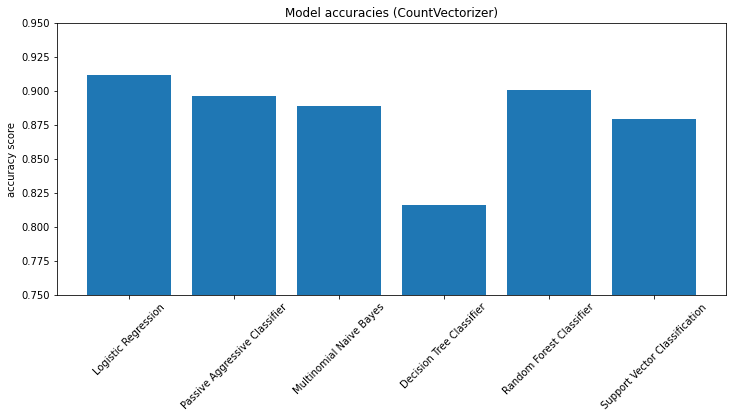

In [30]:
plt.figure(figsize=(12, 5))
plt.bar(models_list, accuracies_list)
plt.xticks(rotation=45)
plt.title('Model accuracies (CountVectorizer)')
plt.ylabel('accuracy score')
plt.ylim(0.75, 0.95);

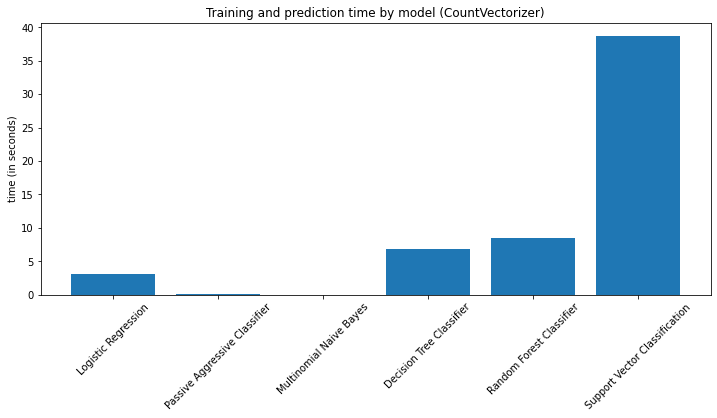

In [31]:
plt.figure(figsize=(12, 5))
plt.bar(models_list, train_predict_times_list)
plt.xticks(rotation=45)
plt.title('Training and prediction time by model (CountVectorizer)')
plt.ylabel('time (in seconds)');

## 8. bag-of-words with TfidfVectorizer

In [32]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8) 
# max_df: ignore terms that appear in more than 80% of the documents

In [33]:
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

In [34]:
X_tfidf_train

<4244x56801 sparse matrix of type '<class 'numpy.float64'>'
	with 1103130 stored elements in Compressed Sparse Row format>

In [35]:
X_tfidf_test = tfidf_vectorizer.transform(X_test.values)

In [36]:
X_tfidf_test

<2091x56801 sparse matrix of type '<class 'numpy.float64'>'
	with 550168 stored elements in Compressed Sparse Row format>

## 9. check the accuracy of the models (text transformed with TfidfVectorizer)

In [ ]:
models_list = []
accuracies_list = []
train_predict_times_list = []

for name, model in models.items():
    # run the model accuracy function
    acc, train_predict_time = model_accuracy(model, X_tfidf_train, y_train, X_tfidf_test, y_test)
    
    # save the results in the above created lists
    models_list.append(name)
    accuracies_list.append(acc)
    train_predict_times_list.append(train_predict_time)
    
    # print the results
    print(f'\nmodel: {name}\naccuracy: {acc}\ntime of training and prediction: {train_predict_time}s')


model: Logistic Regression
accuracy: 0.914
time of training and prediction: 0.7s

model: Passive Aggressive Classifier
accuracy: 0.936
time of training and prediction: 0.08s

model: Multinomial Naive Bayes
accuracy: 0.815
time of training and prediction: 0.04s

model: Decision Tree Classifier
accuracy: 0.803
time of training and prediction: 4.91s

model: Random Forest Classifier
accuracy: 0.897
time of training and prediction: 6.67s


The text is transformed into bag-of-words with TfidfVectorizer. In this case the best performing model is the **Passive Aggressive Classifier** with an **accuracy** of **93,5%** and the training and prediction generation of it is not that time consuming as the Support Vector Classification.

## 10. plot the results (text transformed by the TfidfVectorizer)

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(models_list, accuracies_list)
plt.xticks(rotation=45)
plt.title('Model accuracies (CountVectorizer)')
plt.ylabel('accuracy score')
plt.ylim(0.75, 0.95);

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(models_list, train_predict_times_list)
plt.xticks(rotation=45)
plt.title('Training and prediction time by model (CountVectorizer)')
plt.ylabel('time (in seconds)');

## 11. tune the hyperparameters of the best performing model
Passive Aggressive Classifier (text transformed by TfidfVectorizer)

**check different values of C (regularization parameter)**

In [ ]:
training_accuracy = []
test_accuracy = []
# C is a regularization parameter. Smaller values specify stronger regularization.
# default C = 1.0
c_range = [0.001, 0.01, 0.1, 1, 10]

for c in c_range:
    # build the model
    model = PassiveAggressiveClassifier(C=c, random_state=42)
    # train the model
    model.fit(X_tfidf_train, y_train)
    # record training set accuracy
    training_accuracy.append(model.score(X_tfidf_train, y_train))
    # record generalization accuracy
    test_accuracy.append(model.score(X_tfidf_test, y_test))

In [ ]:
c_range

In [ ]:
[round(a, 3) for a in training_accuracy]

In [ ]:
[round(a, 3) for a in test_accuracy]

In [ ]:
res = {c_range[i]: [training_accuracy[i], test_accuracy[i]] for i in range(len(c_range))}

In [ ]:
res_df = pd.DataFrame(res, index=['train_acc', 'test_acc'])
res_df

**plot the accuracy results**

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(c_range, training_accuracy, label='training accuracy')
plt.plot(c_range, test_accuracy, label='test accuracy')
plt.ylabel('accuray')
plt.xlabel('c_range')
plt.legend()
plt.xscale('log');
# plt.xlim(0, 2);

## 12. evaluate the best performing model more in details
Passive Aggressive Classifier (text transformed by TfidfVectorizer)

In [ ]:
acc_pac, time_pac = (model_accuracy(PassiveAggressiveClassifier, 
                                    X_tfidf_train, 
                                    y_train, 
                                    X_tfidf_test, 
                                    y_test)) # model_parameters={'C':0.1}
acc_pac

In [ ]:
pac_model = PassiveAggressiveClassifier(C=0.1, random_state=42)

time_start = time.time()

pac_model.fit(X_tfidf_train, y_train)
y_pred_pac = pac_model.predict(X_tfidf_test)
acc_pac = accuracy_score(y_test, y_pred_pac)

time_end = time.time() - t0
print(f'{round(fit_time, 3)}s')

In [ ]:
round(acc_pac, 3)

In [ ]:
y_test.value_counts()

In [ ]:
cm_pac = confusion_matrix(y_test, y_pred_pac, labels=['REAL', 'FAKE'])
cm_pac

Out of 1071 (57+1014) actual fake news the model found 1014. **recall(FN)** = 1014/1071 = 94,68%

Out of 1079 (65+1014) fake predictions of the model, 1014 are really fake. **precision(FP)** = 1014/1079 = 93.98% 

In [ ]:
precision_pac = precision_score(y_test, y_pred_pac, pos_label='FAKE')
precision_pac

In [ ]:
recall_pac = recall_score(y_test, y_pred_pac, pos_label='FAKE')
recall_pac

In [ ]:
#f-score is the harmonic weighted average of precision and recall
f_score_pac = f1_score(y_test, y_pred_pac, pos_label='FAKE')
f_score_pac

In [ ]:
class_rep_pac = classification_report(y_test, y_pred_pac) # target_names=['FAKE', 'REAL']
print(class_rep_pac)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(cm_pac, classes=['REAL', 'FAKE'])

## 13. make some predictions
The model should be trained on BBC news as well.

In [ ]:
# source: https://www.bbc.com/news/live/election-us-2020-54768270
input_text1 = '''Just days before polling day, another tragedy, followed by nights of unrest, highlighted a central issue in this US election - but what exactly that issue is depends upon which side of the great American divide the voter finds themselves. For some, the fatal shooting by police of Walter Wallace in Philadelphia is yet more evidence that sweeping change is needed to tackle the twin scourges of police brutality and systemic racism. For some Americans though, it is the civil unrest in the aftermath of the killing that is their focus. President Trump speaks to those voters with his strong law and order messaging, talking of the rioting and looting.'''
prediction1 = pac_model.predict(tfidf_vectorizer.transform([input_text1]))
prediction1

In [ ]:
# source: https://www.bbc.com/news/live/election-us-2020-54768270
input_text2 = '''President Trump took time out before a busy day of campaigning to pay tribute to the Scottish actor Sir Sean Connery, whose death at the age of 90 was announced on Friday. Mr Trump described him as "quite a guy, and a tough character" and said he had gone on to "greener fairways" before claiming that the actor had helped him get approval for a development in Scotland. "Sean stepped in and shouted 'Let him build the damn thing'," the president claimed. In 2018 British media reported that Mr Trump had made a similar claim to then UK Prime Minister Theresa May, relating to approval for his Turnberry golf course in South Ayrshire. "I met James Bond and I got all my approvals," the Sunday Times quoted him as saying, adding: "James Bond was better than my approvals lawyer." However Sir Sean did not make any public comment confirming this. In 2012 Mr Trump made the Bond actor the first member of his golf club in Aberdeenshire.'''
prediction2 = pac_model.predict(tfidf_vectorizer.transform([input_text2]))
prediction2

In [ ]:
# source: https://www.bbc.com/news/live/election-us-2020-54768270
input_text3 = '''The Biden campaign cancelled an event in Texas after it said a convoy of Trump supporters tried to stop a bus on a highway in the state. Staff on the bus called 911 as cars flying Trump flags pulled in front and slowed down as the bus was travelling from San Antonio to Austin, the Biden campaign said. Video of one pro-Trump vehicle appearing to strike another vehicle was posted on social media. Police later escorted the bus to its destination, according to the Washington Post newspaper. The Biden campaign then cancelled the planned event "for security reasons", according to Democratic Congresswoman Sheryl Cole. “Rather than engage in productive conversation about the drastically different visions that Joe Biden and Donald Trump have for our country, Trump supporters in Texas [Friday] instead decided to put our staff, surrogates, supporters, and others in harm’s way,” local Biden campaign spokesman Tariq Thowfeek told US media. President Trump later tweeted "I love Texas!" along with a video showing his supporters surrounding the bus. Polls in the state have tightened but still show Mr Trump with a narrow lead, according to Real Clear Politics.'''
prediction3 = pac_model.predict(tfidf_vectorizer.transform([input_text3]))
prediction3

In [ ]:
# source: https://www.bbc.com/news/live/election-us-2020-54768270
input_text4 = '''One big trend in this election season has been Americans getting to the polls early. As of today, some 92,038,417 ballots have already been cast by voters, about one-third of them in-person - 33,141,215 - and the rest - 58,897202 - by mail. That includes both Donald Trump and Joe Biden, and their respective running mates Mike Pence and Kamala Harris, who have all voted early. In Texas, early votes have surpassed the total number of votes cast in the last general election. On a national level, voters have already cast 66.8%of the total votes counted in the 2016 election, according to the US Elections Project. Election Day - 3 November - is this Tuesday.'''
prediction4 = pac_model.predict(tfidf_vectorizer.transform([input_text4]))
prediction4

In [ ]:
# source: https://www.bbc.com/news/health-54712917
input_text5 = '''There's no stopping the second wave of coronavirus, it seems, despite a bundle of new rules designed to do just that. Infection rates are rising rapidly, with estimates suggesting up to 100,000 people a day may be catching the virus. Across the Channel, France has admitted its regional approach is not working, by announcing a new national lockdown. Germany, to a lesser extent, is also planning one. Wales is in the middle of a short "fire-breaker" lockdown, in which bars, restaurants, churches and most shops have shut for a fortnight. So is a full-on UK-wide lockdown only a matter of time? Many of those advising government have given it their backing. Sir Jeremy Farrar, a member of the Scientific Advisory Group for Emergencies (Sage), which advises ministers, says it should have happened already - and definitely needs to now. Any delay, he said, will be costly and will mean later restrictions will be "harder and longer". The tools we have at our disposal are not proving effective, said Dr Duncan Robertson, a disease modeller at Loughborough University. The test-and trace-system, designed to nip outbreaks in the bud, can't cope, he said. The service has consistently failed to reach enough close contacts of people who test positive. It's just a "matter of time" before a lockdown is introduced, he believes.'''
prediction5 = pac_model.predict(tfidf_vectorizer.transform([input_text5]))
prediction5

## 14. export (dump) the tfidf_vectorizer and the model

In [ ]:
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

In [ ]:
with open('pac_model.pkl', 'wb') as file:
    pickle.dump(pac_model, file)

## 15. check: import (load) the pickled tfidf_vectorizer and the model

In [ ]:
with open('tfidf_vectorizer.pkl', 'rb') as file:
    imported_vectorizer = pickle.load(file)

In [ ]:
with open('pac_model.pkl', 'rb') as file:
    imported_model = pickle.load(file) 

In [ ]:
# source = https://www.bbc.com/news/uk-54772375
input_text6 = '''Greater Manchester Mayor Andy Burnham and Liverpool City Region Mayor Steve Rotherham said that education institutions should close to reduce the spread of the virus more quickly. Scientists have also warned Covid-19 is spreading fast in secondary schools. But cabinet minister Michael Gove said: "We want to keep schools open." Mr Gove told the BBC's Andrew Marr Show that the government was taking the necessary measures to keep schools open. He rejected the suggestion that it would mean a longer period of lockdown because schools staying open would contribute to the continued transmission of coronavirus. Schools may need to shut to some years - scientist. Emergency powers to require schools to teach online. What happens if someone at school tests positive? Infection rates among secondary school children "appear to be steeply increasing", according to the latest survey by the Office of National Statistics. An estimated 2% of children in Year 7 to Year 11 tested positive for the virus in the most recent week of testing, the highest positivity rate of any age group except sixth-formers and young adults. Sir Jeremy Farrar, a member of the government's Scientific Advisory Group for Emergencies (Sage), told the Andrew Marr Show that keeping schools open was the "big difference" between the new restrictions and the lockdown in spring. "Because we have delayed the onset of this lockdown it does make keeping schools open harder," he said. "We know that transmission, particularly in secondary schools, is high." He said that closing schools "may have to be revisited" over the next four weeks if the transmission of the virus continues to rise.'''
prediction6 = imported_model.predict(imported_vectorizer.transform([input_text6]))
prediction6